In [32]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use("https://github.com/mlefkir/beauxgraphs/raw/main/beautifulgraphs_colblind.mplstyle")

# Gaussian process method

Here, we describe how to generate a random time series using the Gaussian process method. 

## Description

### Basic idea
Given a random process described with either a Power Spectral Density (PSD) or an autocovariance function (ACVF), the Gaussian Process method allows drawing a realisation of this process. The main idea is to draw the time series from a multivariate normal distribution (Eq. {math:numref}`eq:multigauss`) with a covariance matrix $\Sigma$ that is given by the PSD or ACVF.


```{eval-rst}
.. math::
    :name: eq:multigauss
    
    p(\boldsymbol{y}| \boldsymbol{m},\Sigma) =\dfrac{1}{(2\pi)^{n/2} | \Sigma |^{1/2}} \exp{ \left( -\dfrac{1}{2} \left(\boldsymbol{y}-\boldsymbol{m} \right)^{\rm T} {\Sigma}^{-1}  \left(\boldsymbol{y}-\boldsymbol{m} \right) \right) }
```


If the PSD is given, the ACVF is computed as the inverse Fourier transform of the PSD. To reduce distortions due to aliasing and leakage, the range of frequencies in the PSD is extended, see more details in the Notebook [on the FFT](../references/On_the_fft.ipynb). The discretised ACVF is then interpolated to the desired time lags. 

### Drawing samples from a multivariate normal distribution

To easily draw samples, we compute the Cholesky decomposition of the covariance matrix $\Sigma$ decomposition with the function {func}`jax.numpy.linalg.cholesky`. The Cholesky decomposition is a lower triangular matrix $L$ such that $\Sigma = L L^{\rm T}$. Random numbers from a multivariate normal distribution can then be drawn by multiplying a vector of independent standard normal random variables with $L$.



### Implementation in `pioran`

This method is implemented in the class {class}`~pioran.simulate.Simulations` via the method {meth}`~pioran.simulate.Simulations.GP_method`. The method takes as input the PSD or ACVF, the number of samples and the sampling frequency. The output is a time series of the same length as the PSD or ACVF.



## Usage

The first thing to do is to define the parameters of the time series, duration, sampling and model. If the model is a PSD then $S_\mathrm{low}$ and $S_\mathrm{high}$ must be given.
All of these are given to the initialisation of a {class}`~pioran.simulate.Simulations` object.

In [33]:
from pioran import Simulations
from pioran.acvf import Exponential
from pioran.psd import Lorentzian

acv_model = Exponential([1,1e-2])
psd_model = Lorentzian([0.00,1,1e-2])

duration = 400
dt = 1.5
Sim = Simulations(T=duration,dt=dt,model=acv_model)
Sim_psd = Simulations(T=duration,dt=dt,model=psd_model,S_high=20,S_low=20)

We can plot the autocovariance function of the model:

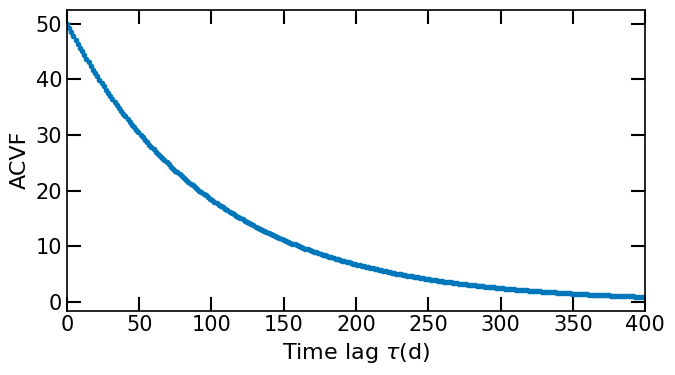

In [34]:
fig,ax = Sim.plot_acvf(figsize=(7,4))

To generate a random time series we use the {meth}`~pioran.simulate.Simulations.simulate` method. We specify the method to use with `method='GP'`. By default, the values of the time series are randomised with a normal distribution. This can be changed with the `randomise_fluxes` argument. The errors are assumed to be Gaussian.

By default, the mean of the time series is shifted to twice the minimum of the time series to get a positive-valued time series. This can be changed with the `mean` argument.

In [35]:
t, ts, ts_err = Sim.simulate(method='GP',seed=342)
t_psd, ts_psd, ts_psd_err = Sim_psd.simulate(method='GP',seed=342)

Calculating the autocovariance function
Interpolating the autocovariance function


We can see that the time series obtained using a PSD and an ACVF are identical.

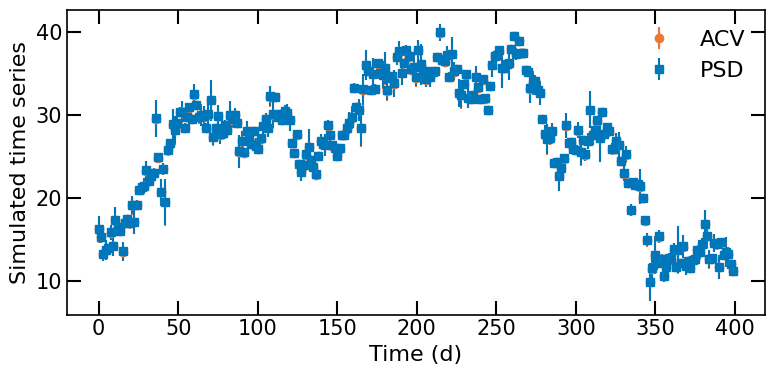

In [36]:
fig, ax = plt.subplots(figsize=(8,4))
ax.errorbar(t_psd,ts_psd,yerr=ts_psd_err,fmt='o',color='C3')
ax.errorbar(t,ts,yerr=ts_err,fmt='s')
ax.set_xlabel('Time (d)')
ax.set_ylabel('Simulated time series')
ax.legend(['ACV','PSD'])
fig.tight_layout()

## References

Rasmussen, C. E., & Williams, C. K. I. Gaussian processes for machine learning. (2006) MIT press. 